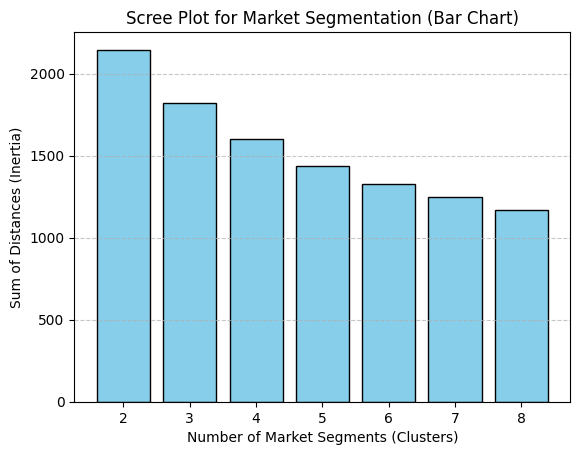

In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

np.random.seed(1234)

df =pd.read_csv("/content/sample_data/mcdonalds.csv")
MD = np.where(df.iloc[:, :11] == "Yes", 1, 0)
MD_df =pd.DataFrame(MD, columns=df.columns[:11])

cluster_results={}

for k in range(2,9):
    best_model =None
    best_inertia = np.inf
    for _ in range(10):
        kmeans = KMeans(n_clusters=k,random_state=np.random.randint(10000), n_init=10)
        kmeans.fit(MD_df.values)
        if kmeans.inertia_ <best_inertia:
            best_model = kmeans
            best_inertia = kmeans.inertia_
    cluster_results[k]= best_model



k_values = list(cluster_results.keys())
inertia_values = [model.inertia_ for model in cluster_results.values()]

plt.bar(k_values, inertia_values, color='skyblue', edgecolor='black')

plt.xlabel("Number of Market Segments (Clusters)")
plt.ylabel("Sum of Distances (Inertia)")
plt.title("Scree Plot for Market Segmentation (Bar Chart)")
plt.xticks(k_values)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<ipython-input-6-7ebb98d54410>:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stability_scores[k] for k in k_range], labels=k_range)


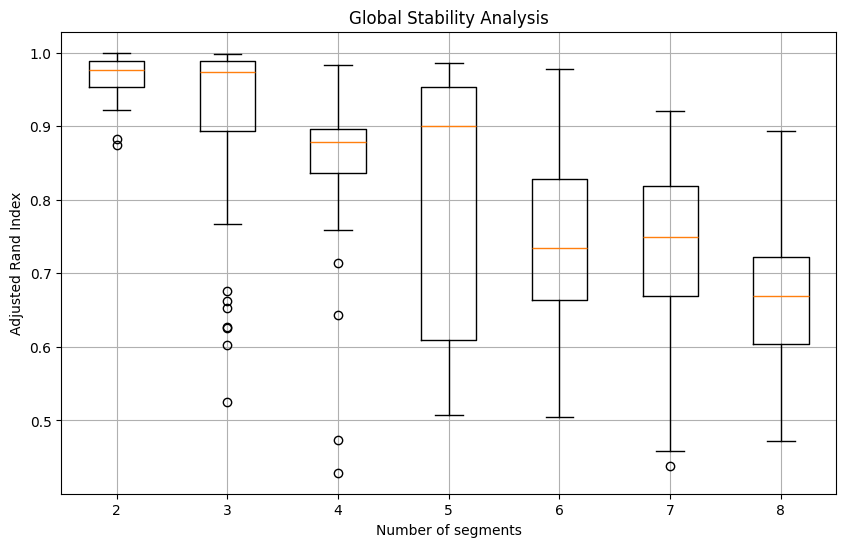

In [6]:
np.random.seed(1234)

k_range = range(2, 9)
n_boot = 100
n_init = 10

stability_scores = {k: [] for k in k_range}

reference_models = {}
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=1234)
    reference_models[k] = kmeans.fit_predict(MD_df.values)

for k in k_range:
    for _ in range(n_boot):
        boot_sample = resample(MD_df.values, replace=True)

        kmeans_boot = KMeans(n_clusters=k, n_init=n_init)
        boot_labels = kmeans_boot.fit_predict(boot_sample)

        full_labels = kmeans_boot.predict(MD_df.values)

        ari = adjusted_rand_score(reference_models[k], full_labels)
        stability_scores[k].append(ari)

plt.figure(figsize=(10, 6))
plt.boxplot([stability_scores[k] for k in k_range], labels=k_range)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability Analysis')
plt.grid(True)
plt.show()

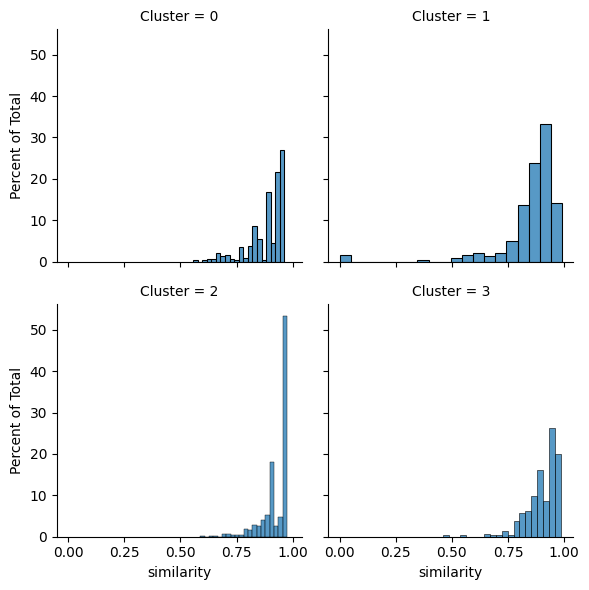

In [7]:
np.random.seed(1234)

kmeans = KMeans(n_clusters=4, random_state=1234, n_init=10)
MD_df['Cluster'] = kmeans.fit_predict(MD_df.values)

from sklearn.metrics.pairwise import cosine_similarity
similarities = []
for index, row in MD_df.iterrows():
    cluster_center = kmeans.cluster_centers_[row['Cluster']]
    sim = cosine_similarity([row[:-1]], [cluster_center])[0, 0]
    similarities.append(sim)

MD_df['Similarity'] = similarities

g = sns.FacetGrid(MD_df, col="Cluster", col_wrap=2, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="Similarity", bins=20, stat="percent")
g.set_axis_labels("similarity", "Percent of Total")
plt.show()


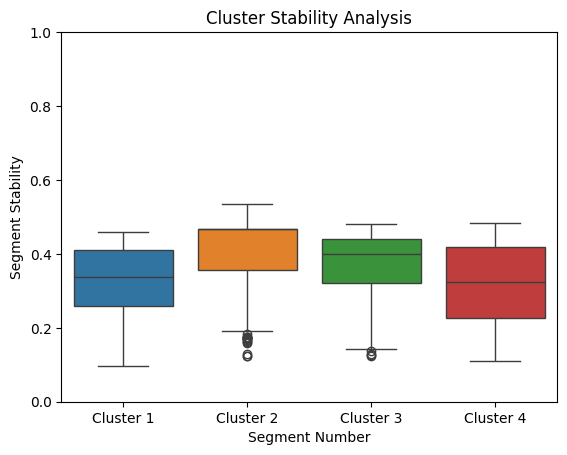

In [8]:
np.random.seed(1234)

kmeans = KMeans(n_clusters=4, n_init=10, random_state=1234)
cluster_labels = kmeans.fit_predict(MD_df.values)

silhouette_vals = silhouette_samples(MD_df.values, cluster_labels)
segment_data = {f"Cluster {i+1}": silhouette_vals[cluster_labels == i] for i in range(4)}

sns.boxplot(data=list(segment_data.values()))
plt.xticks(range(4), list(segment_data.keys()))
plt.ylim(0, 1)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.title("Cluster Stability Analysis")
plt.show()


In [9]:
np.random.seed(1234)

results = []

for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_df)

    log_likelihood = -gmm.lower_bound_ * len(MD_df)
    aic =np.round(gmm.aic(MD_df),2)
    bic = np.round(gmm.bic(MD_df),2)

    responsibilities = gmm.predict_proba(MD_df)
    entropy_term = np.sum(responsibilities * np.log(responsibilities + 1e-10))
    icl = np.round(bic + 2 * entropy_term ,2)

    results.append([k, log_likelihood, -aic, -bic, -icl])

df_results = pd.DataFrame(results, columns=["k", "logLik", "AIC", "BIC", "ICL"])
print(df_results)


   k        logLik       AIC       BIC       ICL
0  2  -6064.777874  11711.56  10607.75  10608.27
1  3  -5574.282741  10520.57   8862.21   8862.21
2  4 -14543.662954  28249.33  26036.43  26036.43
3  5 -22663.462392  44278.92  41511.48  41511.48
4  6 -22578.283217  43898.57  40576.57  40576.57
5  7 -25158.457246  48848.91  44972.38  44972.38
6  8 -28308.073459  54938.15  50507.06  50507.07


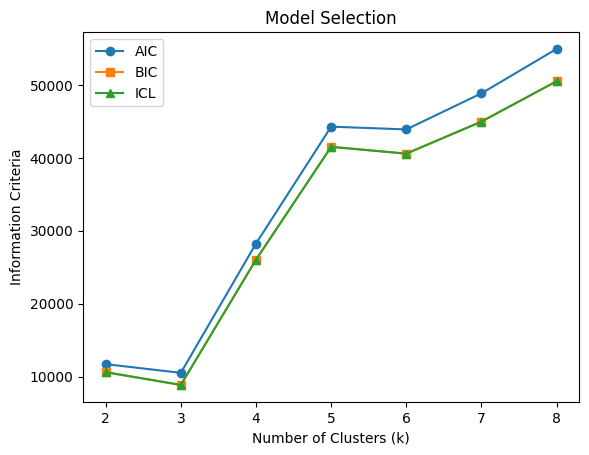

In [24]:
plt.plot(df_results["k"], df_results["AIC"], label="AIC", marker="o")
plt.plot(df_results["k"], df_results["BIC"], label="BIC", marker="s")
plt.plot(df_results["k"], df_results["ICL"], label="ICL", marker="^")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Information Criteria")
plt.title("Model Selection")
plt.legend()
plt.show()


In [11]:
gmm_4 = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm_4.fit(MD_df)

mixture_labels = gmm_4.predict(MD_df)


In [25]:
kmeans = KMeans(n_clusters=4, random_state=1234, n_init=10)
kmeans_labels = kmeans.fit_predict(MD_df)

conf_matrix = pd.DataFrame(confusion_matrix(kmeans_labels, mixture_labels))
print("k-Means vs GMM")
print(conf_matrix)


k-Means vs GMM
     0    1    2    3
0    0  240    0    0
1    0    0  133  400
2    0  364    0    0
3  316    0    0    0


In [26]:
gmm_refit = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm_refit.fit(MD_df)

mixture_refit_labels = gmm_refit.predict(MD_df)

conf_matrix_refit = pd.DataFrame(confusion_matrix(kmeans_labels, mixture_refit_labels))
print("k-Means vs GMM Refit")
print(conf_matrix_refit)


k-Means vs GMM Refit
     0    1    2    3
0    0  240    0    0
1    0    0  133  400
2    0  364    0    0
3  316    0    0    0


In [27]:
log_lik_original = gmm_4.lower_bound_ * len(MD_df)
log_lik_refit = gmm_refit.lower_bound_ * len(MD_df)

print(f"Original GMM Model: {log_lik_original:.3f}")
print(f"GMM Refit Model: {log_lik_refit:.3f}")


Original GMM Model: 14543.663
GMM Refit Model: 14543.663


In [15]:
mcdonalds =df.copy()
mcdonalds["Like_n"] = 6 - mcdonalds["Like"].astype("category").cat.codes
print(mcdonalds["Like_n"].value_counts().sort_index(ascending=False))

Like_n
 6    152
 5    187
 4    229
 3    160
 2     58
 1     59
 0     73
-1     71
-2    169
-3    152
-4    143
Name: count, dtype: int64


In [16]:
from patsy import dmatrices

mcdonalds.iloc[:, :11] = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)
mcdonalds["Like_n"] = pd.to_numeric(mcdonalds["Like"], errors="coerce")
formula = "Like_n ~ " + " + ".join(mcdonalds.columns[:11])
y, X = dmatrices(formula, mcdonalds, return_type="dataframe")


<ipython-input-16-ee77119c6221>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mcdonalds.iloc[:, :11] = mcdonalds.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)


In [17]:
mcdonalds.dropna(inplace=True)

In [18]:
from sklearn.mixture import GaussianMixture
np.random.seed(1234)
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm.fit(X)
mcdonalds["Cluster"] = gmm.predict(X)

In [19]:
mcdonalds

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender,Like_n,Cluster
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,Every three months,Female,-3.0,0
1,1,1,0,1,1,1,1,1,1,0,0,+2,51,Every three months,Female,2.0,0
2,0,1,1,1,1,1,0,1,1,1,0,+1,62,Every three months,Female,1.0,0
3,1,1,0,1,1,1,1,1,0,0,1,+4,69,Once a week,Female,4.0,1
4,0,1,0,1,1,1,1,0,0,1,0,+2,49,Once a month,Male,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,0,1,0,1,1,0,0,1,1,0,0,0,43,Once a month,Male,0.0,1
1449,1,1,0,1,0,0,1,1,0,1,0,+2,36,Once a week,Female,2.0,1
1450,1,1,0,1,0,1,0,1,1,0,0,+3,52,Once a month,Female,3.0,0
1451,1,1,0,0,0,1,1,1,0,1,0,+4,41,Every three months,Male,4.0,0


In [20]:
from sklearn.linear_model import LogisticRegression

mcdonalds["Like_n"] = (mcdonalds["Like_n"] >= 3).astype(int)

class_1 = mcdonalds[mcdonalds["Cluster"] == 0].copy()
class_2 = mcdonalds[mcdonalds["Cluster"] == 1].copy()

X_class_1 = class_1.iloc[:, :11]
X_class_2 = class_2.iloc[:, :11]
y_class_1 = class_1["Like_n"]
y_class_2 = class_2["Like_n"]

logit_1 = LogisticRegression().fit(X_class_1, y_class_1)
logit_2 = LogisticRegression().fit(X_class_2, y_class_2)

print("Latent Class 1 Logistic Regression:")
print("Intercept:", logit_1.intercept_)
print("Coefficients:", logit_1.coef_)
print("Accuracy:", logit_1.score(X_class_1, y_class_1))

print("\nLatent Class 2 Logistic Regression:")
print("Intercept:", logit_2.intercept_)
print("Coefficients:", logit_2.coef_)
print("Accuracy:", logit_2.score(X_class_2, y_class_2))

Latent Class 1 Logistic Regression:
Intercept: [-1.83772438]
Coefficients: [[ 1.70924586 -0.00300267 -0.38986775 -0.56456225 -0.48518392 -0.00300267
   0.03165645  1.01336645  0.08961838  0.29478307  0.        ]]
Accuracy: 0.6957547169811321

Latent Class 2 Logistic Regression:
Intercept: [-3.95253617]
Coefficients: [[ 2.69743476  0.51423758 -0.21665383  0.02728372  0.00635919  0.18797744
   0.28249285  0.71361893 -0.03657145  0.55824273 -1.00666485]]
Accuracy: 0.8806451612903226


In [28]:
kmeans = KMeans(n_clusters=2, random_state=1234, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

conf_matrix = pd.DataFrame(confusion_matrix(kmeans_labels, mcdonalds["Cluster"]))
print("k-Means vs Mixture Model")
print(conf_matrix)


k-Means vs Mixture Model
     0    1
0  261  183
1  587  127


In [22]:
log_likelihood = gmm.lower_bound_ * len(X)
print(f"Log Likelihood: {log_likelihood:.3f}")


Log Likelihood: 17025.151


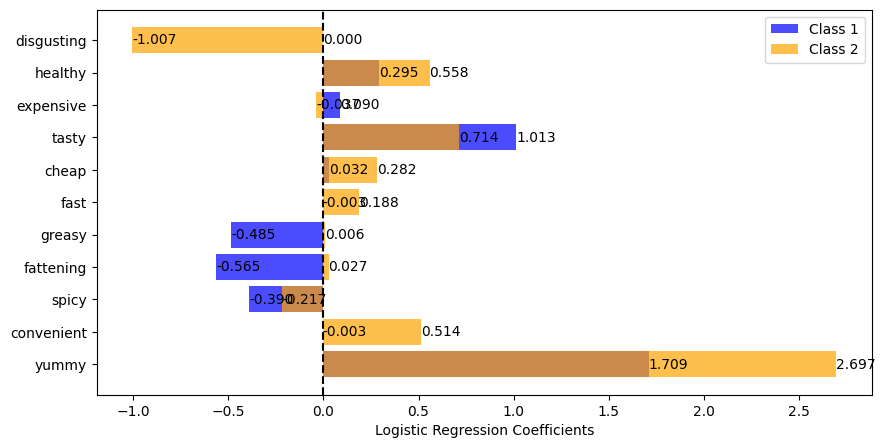

In [29]:
logit_1 = LogisticRegression().fit(X_class_1, y_class_1)
logit_2 = LogisticRegression().fit(X_class_2, y_class_2)

coefficients_1 = logit_1.coef_[0]
coefficients_2 = logit_2.coef_[0]

plt.figure(figsize=(10, 5))
x_labels = X_class_1.columns

plt.barh(x_labels, coefficients_1, alpha=0.7, label="Class 1", color="blue")
plt.barh(x_labels, coefficients_2, alpha=0.7, label="Class 2", color="orange")

for i, (coef1, coef2) in enumerate(zip(coefficients_1, coefficients_2)):
    plt.text(coef1, i, f"{coef1:.3f}", va='center', fontsize=10, color="black")
    plt.text(coef2, i, f"{coef2:.3f}", va='center', fontsize=10, color="black")

plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Logistic Regression Coefficients")

plt.legend()
plt.show()
